
# Modelling deformations of the cross section (brazing)


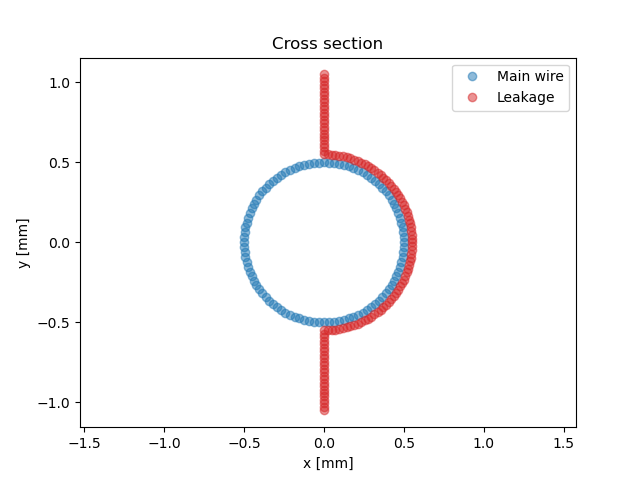

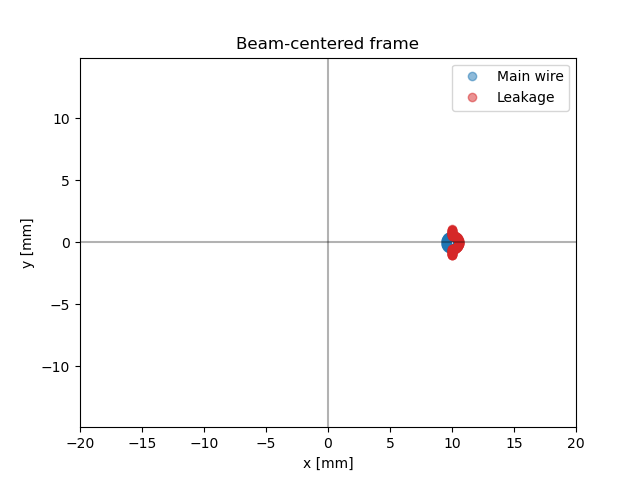

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from rich.progress import track as pbar
from rich import inspect as Inspect

# Custom packages
import Backend.Constants as cst
import Backend.WCTools as WCTools
import Backend.MADXTools as MADXTools


# General parameters
I_total  = 350     # Current in the wire [A]
R_w      = 1e-3/2  # Radius of the wire
r_w      = 10e-3   # Position (vertical) of the wire w.r.t. the beam

# Leakage parameters
eta_leak   = 10e-2         # leakage percentage 
wings_leak = R_w          # Extra wings on both sides of the wire (brazing)
thick_leak = 0.1*R_w      # Distance leakage layer from the wire surface


# Generating wire 
n_subs = 100
_phi = np.linspace(0,2*np.pi,n_subs+1)[:-1]
main_wire = [WCTools.wire(x=R_w*np.cos(_phii),y=R_w*np.sin(_phii),I = I_total*(1-eta_leak)/n_subs,L=1) for _phii in _phi]

# Generating leakage wire
n_subs  = 120
n_wings = int(n_subs/5)
_phi = np.linspace(np.pi,2*np.pi,n_subs-2*n_wings+1)[:-1]
leak_wire = [WCTools.wire(x=(R_w+thick_leak)*np.cos(_phii),y=(R_w+thick_leak)*np.sin(_phii),I = I_total*(eta_leak)/n_subs,L=1) for _phii in _phi]
leak_wire += [WCTools.wire(x=_x,y=0,I = I_total*(eta_leak)/n_subs,L=1) for _x in np.linspace(R_w+thick_leak,R_w+thick_leak+wings_leak,n_wings)]
leak_wire += [WCTools.wire(x=_x,y=0,I = I_total*(eta_leak)/n_subs,L=1) for _x in np.linspace(-(R_w+thick_leak+wings_leak),-(R_w+thick_leak),n_wings)][:-1]

# Repositionning wires w.r.t the beam
for sub_wire in main_wire+leak_wire:
    sub_wire.y -= r_w
    
# Putting wire on x axis
for sub_wire in main_wire+leak_wire:
    _x = sub_wire.x
    _y = sub_wire.y
    sub_wire.x,sub_wire.y = -_y,_x
    
        

# Plotting cross section
%matplotlib widget
plt.figure()
plt.title('Cross section')
for sub_wire in main_wire:
    h1, = plt.plot((sub_wire.x-r_w)/1e-3,(sub_wire.y)/1e-3,'o',alpha=0.5,color='C0')
for sub_wire in leak_wire:
    h2, = plt.plot((sub_wire.x-r_w)/1e-3,(sub_wire.y)/1e-3,'o',alpha=0.5,color='C3')
plt.xlabel('x [mm]')
plt.ylabel('y [mm]')
plt.axis('equal')
plt.legend([h1,h2],['Main wire','Leakage'])


# Plotting in beam chamber
plt.figure()
plt.title('Beam-centered frame')
for sub_wire in main_wire:
    h1, = plt.plot(sub_wire.x/1e-3,sub_wire.y/1e-3,'o',alpha=0.5,color='C0')
for sub_wire in leak_wire:
    h2, = plt.plot(sub_wire.x/1e-3,sub_wire.y/1e-3,'o',alpha=0.5,color='C3')
plt.axhline(0,alpha=0.3,color='k')
plt.axvline(0,alpha=0.3,color='k')
plt.xlabel('x [mm]')
plt.ylabel('y [mm]')
plt.axis('equal')
plt.xlim([-20,20])
plt.ylim([-15,15])

plt.legend([h1,h2],['Main wire','Leakage'])

# Looking at magnetic field

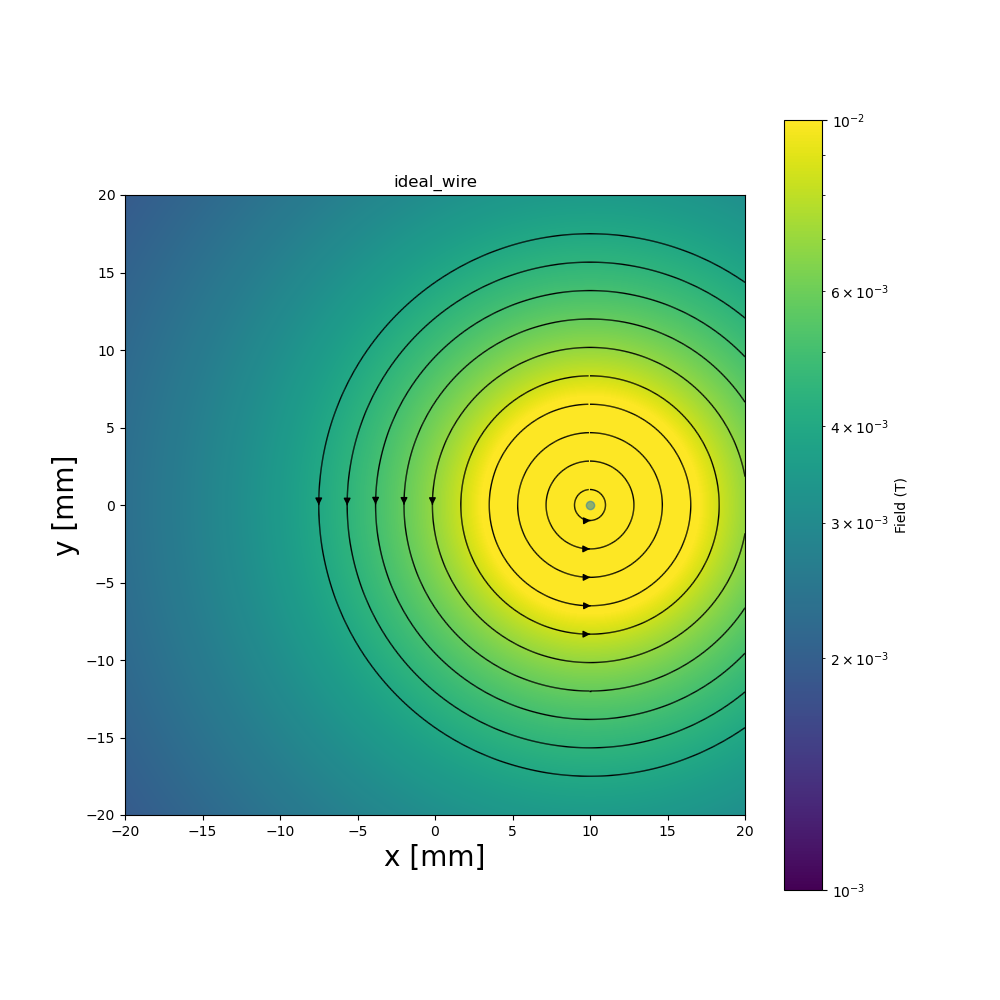

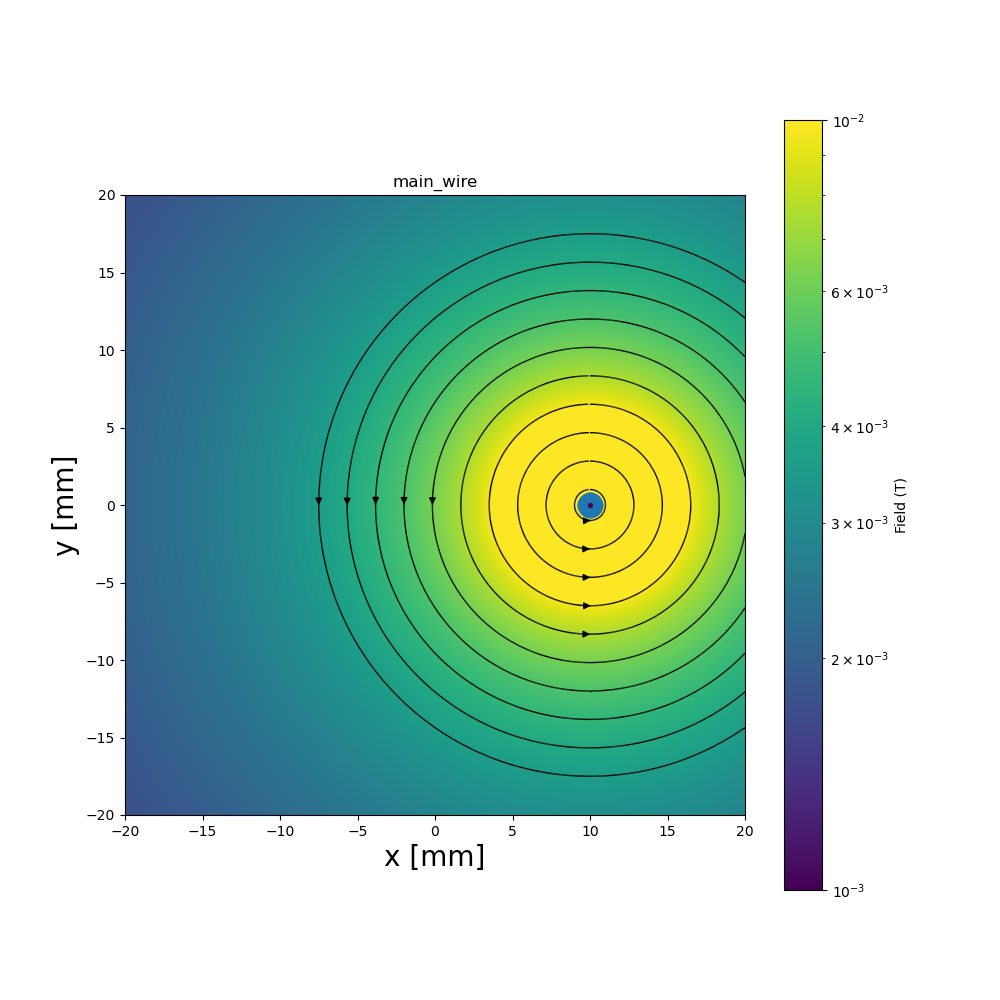

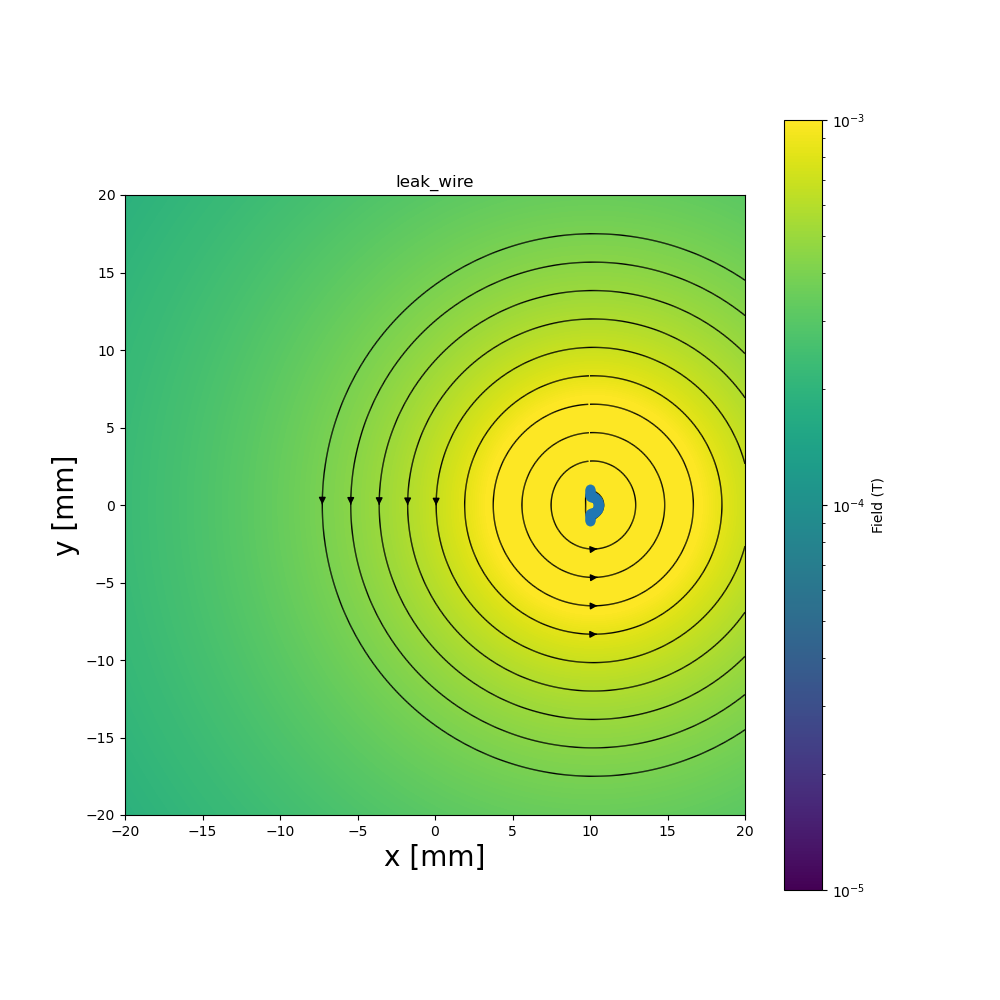

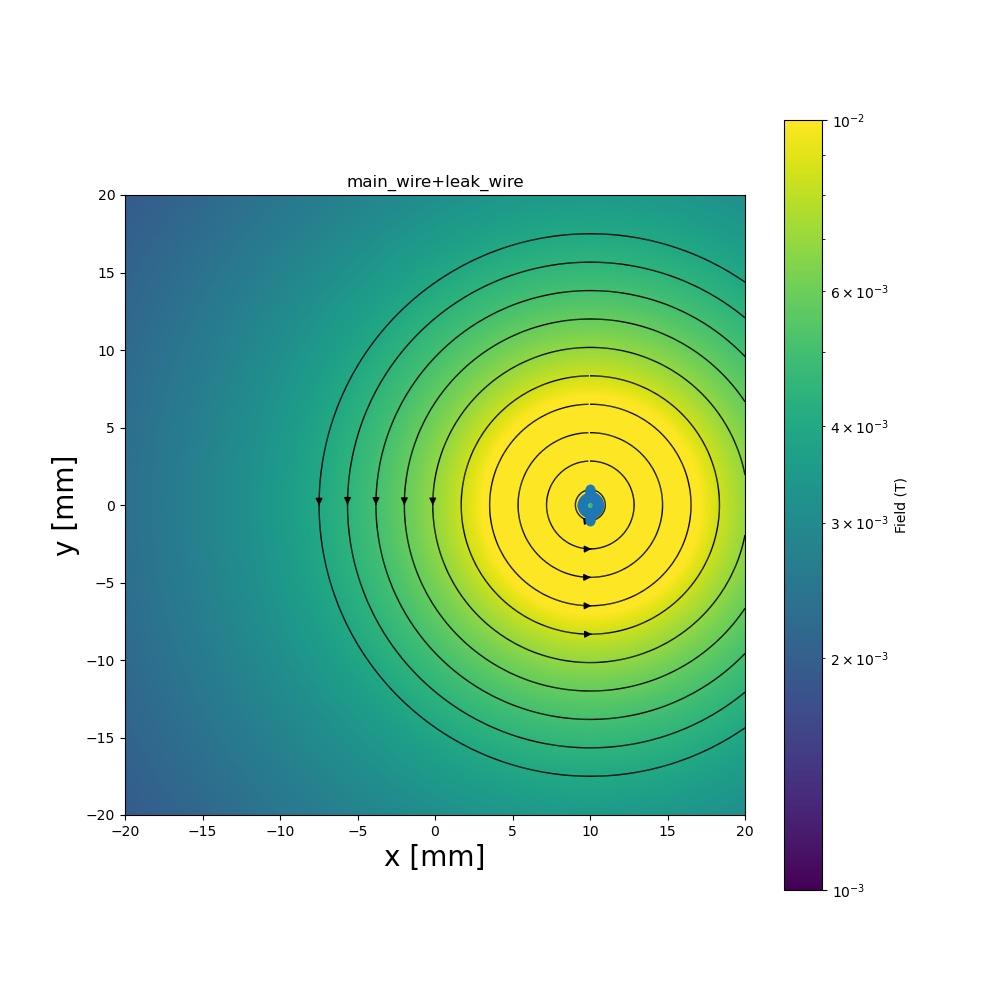

In [2]:
%matplotlib widget

xVec = np.linspace(-20e-3,20e-3,1000)
xObs,yObs = np.meshgrid(xVec,xVec)

ideal_wire = [WCTools.wire(x=0+r_w,y=0,I = I_total,L=1)]

titles = ['ideal_wire','main_wire','leak_wire','main_wire+leak_wire']
colorLim_list = [[1e-3,1e-2],
                 [1e-3,1e-2],
                 [1e-5,1e-3],
                 [1e-3,1e-2]]
for to_study,title,colorLim in zip([ideal_wire,main_wire,leak_wire,main_wire+leak_wire],titles,colorLim_list):

    Bx,By = 0*xObs,0*xObs
    for sub_wire in to_study:
        _Bx,_By = sub_wire.getField(xObs,yObs)
        Bx += _Bx
        By += _By



    n_seeds = 10
    field_seeds = np.array([np.zeros(n_seeds)+r_w,np.linspace(2*R_w,35*R_w,n_seeds)])

    plt.figure(figsize=(10,10))
    plt.title(title)
    WCTools.plotVecField(xObs,yObs,Bx,By,scaling=1e3,colorLabel='Field (T)',mode='streamplot',seed_points = field_seeds,colorLim = colorLim,norm = 'log')

    for sub_wire in to_study:
        h1, = plt.plot(sub_wire.x/1e-3,sub_wire.y/1e-3,'o',alpha=0.5,color='C0')

    plt.axis('square')
    plt.xlabel('x [mm]',fontsize=20)
    plt.ylabel('y [mm]',fontsize=20)

## Computing error map

Text(0, 0.5, 'y [mm]')

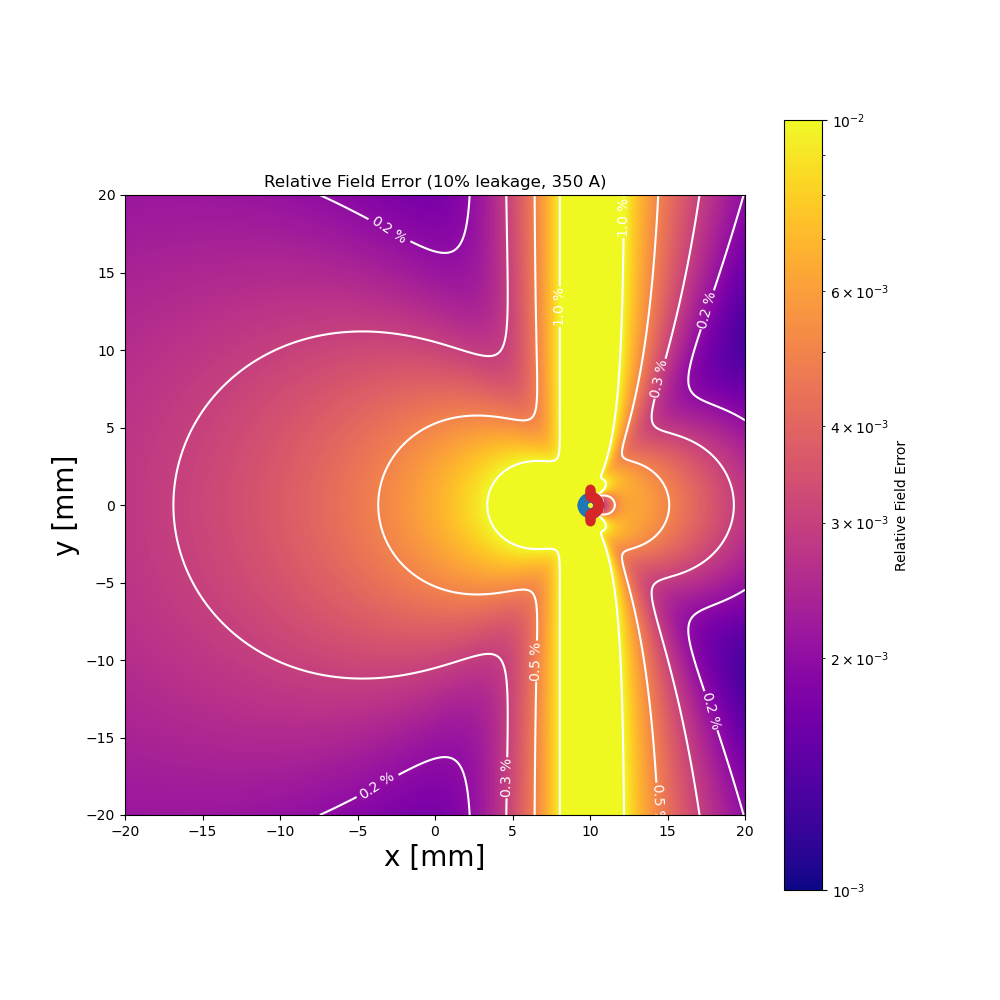

In [4]:
%matplotlib widget

xVec = np.linspace(-20e-3,20e-3,1000)
xObs,yObs = np.meshgrid(xVec,xVec)


Bx_ref,By_ref = 0*xObs,0*xObs
for sub_wire in ideal_wire:
    _Bx,_By = sub_wire.getField(xObs,yObs)
    Bx_ref += _Bx
    By_ref += _By
    

Bx,By = 0*xObs,0*xObs
for sub_wire in main_wire+leak_wire:
    _Bx,_By = sub_wire.getField(xObs,yObs)
    Bx += _Bx
    By += _By


Errx,Erry = np.abs(Bx-Bx_ref)/Bx_ref,np.abs(By-By_ref)/By_ref
colorLim = [1e-3,1e-2]


from matplotlib.colors import LogNorm
plt.figure(figsize=(10,10))
plt.title(f'Relative Field Error ({eta_leak*100:.0f}% leakage, {I_total} A)')
ErrNorm = np.sqrt(Errx**2+Erry**2)
scaling = 1e3
currentExtent =  [scaling*np.min(xObs),scaling*np.max(xObs),scaling*np.min(yObs),scaling*np.max(yObs)]
plt.imshow(ErrNorm, extent = currentExtent,origin='lower',norm = LogNorm(vmin=colorLim[0], vmax=colorLim[1]))
plt.colorbar(label = 'Relative Field Error')
plt.set_cmap('plasma')

levels = [0.2e-2,0.3e-2,0.5e-2,1e-2]
CS = plt.contour(xObs/1e-3,yObs/1e-3,ErrNorm,levels,colors = ['w' for _i in levels])
CS.levels = [rf'{level*100} $\%$' for level in CS.levels ]
plt.clabel(CS,CS.levels, inline=True, fontsize=10)

for sub_wire in main_wire:
    h1, = plt.plot(sub_wire.x/1e-3,sub_wire.y/1e-3,'o',alpha=0.5,color='C0')
for sub_wire in leak_wire:
    h2, = plt.plot(sub_wire.x/1e-3,sub_wire.y/1e-3,'o',alpha=0.5,color='C3')
    
plt.axis('square')
plt.xlabel('x [mm]',fontsize=20)
plt.ylabel('y [mm]',fontsize=20)

# Looking at effect on multipoles

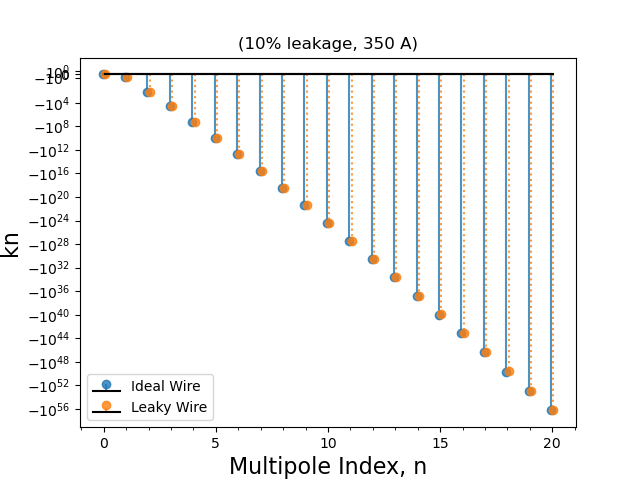

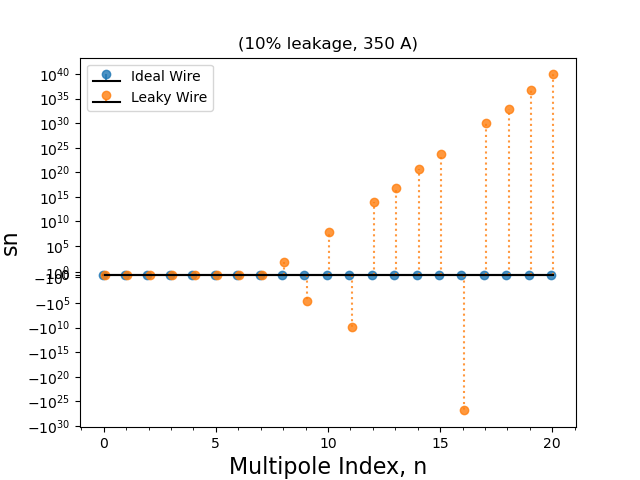

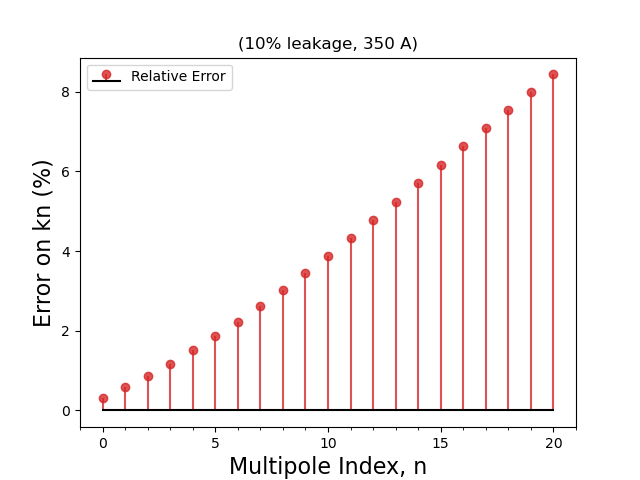

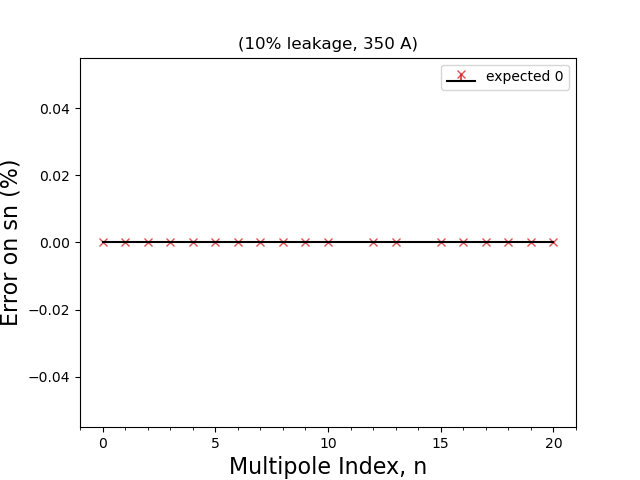

In [5]:
from matplotlib.ticker import MultipleLocator

kn_ref = np.zeros(20 + 1)
sn_ref = np.zeros(20 + 1)
for sub_wire in ideal_wire:
    _kn,_sn = sub_wire.getMultipole_strengths(order=len(kn_ref)-1,normalise_at_E = None)
    kn_ref += _kn
    sn_ref += _sn
    

kn = np.zeros(20 + 1)
sn = np.zeros(20 + 1)
for sub_wire in main_wire+leak_wire:
    _kn,_sn = sub_wire.getMultipole_strengths(order=len(kn)-1,normalise_at_E = None)
    kn += _kn
    sn += _sn



# Plotting parameters
x = np.arange(len(kn))     # the label locations
width = 0.1               # the width of the bars

# Plotting
observables = ['kn','sn']
for obs,obs_ref,observable in zip([kn,sn],[kn_ref,sn_ref],observables):
    plt.figure()
    plt.title(f'({eta_leak*100:.0f}% leakage, {I_total} A)')
    alpha = 0.8
    (markers, stemlines, baseline) = plt.stem(x - width/2, obs_ref, markerfmt = 'C0o' ,linefmt = 'C0-',basefmt = 'k-' ,label='Ideal Wire')
    plt.setp(markers, alpha=alpha)
    plt.setp(stemlines, alpha=alpha)
    (markers, stemlines, baseline) = plt.stem(x + width/2, obs, markerfmt = 'C1o' ,linefmt = 'C1:',basefmt = 'k-' ,label='Leaky Wire')
    plt.setp(markers, alpha=alpha)
    plt.setp(stemlines, alpha=alpha)
    plt.legend()
    plt.yscale('symlog')
    
    ax = plt.gca()
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.xaxis.set_major_formatter('{x:.0f}')

    # For the minor ticks, use no labels; default NullFormatter.
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    
    plt.xlabel('Multipole Index, n',fontsize=16)
    plt.ylabel(f'{observable}',fontsize=16)
    
    
    
    
# Computing Relative Error
observables = ['kn','sn']
for obs,obs_ref,observable in zip([kn,sn],[kn_ref,sn_ref],observables):
    
    err =  np.abs(np.divide((obs-obs_ref),obs_ref,where=obs_ref!=0))
    
    infDivide = (obs_ref==0) & (obs != 0)
    
    plt.figure()
    plt.title(f'({eta_leak*100:.0f}% leakage, {I_total} A)')
    alpha = 0.8
    
    if len(x[np.invert(infDivide)])>0:
        (markers, stemlines, baseline) = plt.stem(x[np.invert(infDivide)] , 100*err[np.invert(infDivide)],bottom =0, markerfmt = 'C3o' ,linefmt = 'C3-',basefmt = 'k-' ,label='Relative Error')
        plt.setp(markers, alpha=alpha)
        plt.setp(stemlines, alpha=alpha)

    if len(x[infDivide])>0:
        (markers, stemlines, baseline) = plt.stem(x[infDivide] , 0*err[infDivide],bottom =0, markerfmt = 'C3x' ,linefmt = 'C3-',basefmt = 'k-' ,label='expected 0')
        plt.setp(markers, alpha=alpha)
        plt.setp(stemlines, alpha=alpha)

    plt.legend()

    ax = plt.gca()
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.xaxis.set_major_formatter('{x:.0f}')

    # For the minor ticks, use no labels; default NullFormatter.
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    
    plt.xlabel('Multipole Index, n',fontsize=16)
    plt.ylabel(f'Error on {observable} (%)',fontsize=16)


# Looking at kick

# IGNORE - Testing field functions

## Along axis

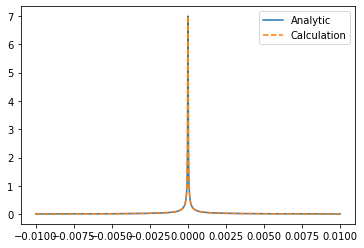

In [31]:
ideal_wire = WCTools.wire(x=0,y=0,I = I_total,L=1)


xVec = np.linspace(-10e-3,10e-3,1000)
Bx,By = thisWire.getField(xVec,0*xVec)


plt.figure()
plt.plot(xVec,4e-7*np.pi*I_total/(2*np.pi*np.abs(xVec)),label='Analytic')
plt.plot(xVec,np.sqrt(Bx**2+By**2),'--',label='Calculation')
plt.legend()

## 2D field map

Text(0, 0.5, 'y [mm]')

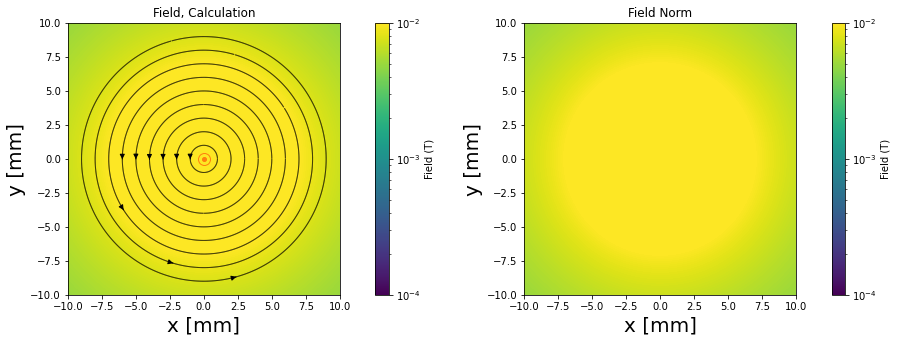

In [32]:
%matplotlib inline

xVec = np.linspace(-10e-3,10e-3,1000)
xObs,yObs = np.meshgrid(xVec,xVec)

ideal_wire = WCTools.wire(x=0,y=0,I = I_total,L=1)


Bx,By = 0*xObs,0*xObs
for thisWire in [ideal_wire]:
    _Bx,_By = thisWire.getField(xObs,yObs)
    Bx += _Bx
    By += _By



n_seeds = 10
field_seeds = np.array([np.linspace(2*R_w,20*R_w,n_seeds),np.zeros(n_seeds)])

fig,axes = plt.subplots(1,2,figsize=(15,5))
plt.sca(axes[0])
plt.title('Field, Calculation')
WCTools.plotVecField(xObs,yObs,Bx,By,scaling=1e3,colorLabel='Field (T)',mode='streamplot',seed_points = field_seeds,colorLim = [1e-4,1e-2],norm = 'log')
for thisWire in [ideal_wire]:
    thisWire.plotWireLocation(scaling=1e3)
plt.axis('square')
plt.xlabel('x [mm]',fontsize=20)
plt.ylabel('y [mm]',fontsize=20)


plt.sca(axes[1])
from matplotlib.colors import LogNorm
plt.title('Field Norm')

BNorm = 4e-7*np.pi*I_total/(2*np.pi*np.sqrt(xObs**2 + yObs**2))
scaling = 1e3
currentExtent =  [scaling*np.min(xObs),scaling*np.max(xObs),scaling*np.min(yObs),scaling*np.max(yObs)]
colorLim = [1e-4,1e-2]
plt.imshow(BNorm, extent = currentExtent,origin='lower',norm = LogNorm(vmin=colorLim[0], vmax=colorLim[1]))
plt.colorbar(label = 'Field (T)')
plt.axis('square')
plt.xlabel('x [mm]',fontsize=20)
plt.ylabel('y [mm]',fontsize=20)

